# Testing the Gaussian Process model

In [ ]:
import numpy as np
from pathlib import Path
import shutil
import warnings

from dipy.core.gradients import gradient_table
from sklearn.gaussian_process import GaussianProcessRegressor

from eddymotion import dmri
from eddymotion.viz import plot_dwi

%matplotlib inline

In [2]:
base_dir = Path("/Users/michael/projects/datasets/ds000206")
bids_dir = base_dir / "bids"
derivatives_dir = base_dir / "dmriprep"

dwi_file = bids_dir / "sub-05" / "ses-JHU1" / "dwi" / "sub-05_ses-JHU1_acq-GD72_dwi.nii.gz"
bvec_file = bids_dir / "sub-05" / "ses-JHU1" / "dwi" / "sub-05_ses-JHU1_acq-GD72_dwi.bvec"
bval_file = bids_dir / "sub-05" / "ses-JHU1" / "dwi" / "sub-05_ses-JHU1_acq-GD72_dwi.bval"
rasb_file = bids_dir / "sub-05" / "ses-JHU1" / "dwi" / "sub-05_ses-JHU1_acq-GD72_dwi.tsv"

b0_file = derivatives_dir / "sub-05" / "ses-JHU1" / "dwi" / "sub-05_ses-JHU1_acq-GD72_desc-b0_dwi.nii.gz"
brainmask_file = derivatives_dir / "sub-05" / "ses-JHU1" / "dwi" / "sub-05_ses-JHU1_acq-GD72_desc-brain_mask.nii.gz"

In [3]:
dmri_dataset = dmri.load(str(dwi_file),
                         gradients_file=str(rasb_file),
                         b0_file=str(b0_file),
                         brainmask_file=str(brainmask_file)
                        )

In [4]:
data_train, data_test = dmri_dataset.logo_split(15, with_b0=True)

In [5]:
def _rasb2dipy(gradient):
    gradient = np.asanyarray(gradient)
    if gradient.ndim == 1:
        if gradient.size != 4:
            raise ValueError("Missing gradient information.")
        gradient = gradient[..., np.newaxis]

    if gradient.shape[0] != 4:
        gradient = gradient.T
    elif gradient.shape == (4, 4):
        print("Warning: make sure gradient information is not transposed!")

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        retval = gradient_table(gradient[3, :], gradient[:3, :].T)
    return retval

def _model_fit(model, data):
    return model.fit(data)

In [6]:
gtab = _rasb2dipy(data_train[1])
param = {}

In [7]:
class SparseFascicleModel:
    """
    A wrapper of :obj:`dipy.reconst.sfm.SparseFascicleModel.
    """

    __slots__ = ("_model", "_S0", "_mask", "_solver")

    def __init__(self, gtab, S0=None, mask=None, solver=None, **kwargs):
        """Instantiate the wrapped model."""
        from dipy.reconst.sfm import SparseFascicleModel

        self._S0 = None
        if S0 is not None:
            self._S0 = np.clip(
                S0.astype("float32") / S0.max(),
                a_min=1e-5,
                a_max=1.0,
            )

        self._mask = mask
        if mask is None and S0 is not None:
            self._mask = self._S0 > np.percentile(self._S0, 35)

        if self._mask is not None:
            self._S0 = self._S0[self._mask.astype(bool)]

        self._solver = solver
        if solver is None:
            self._solver = "ElasticNet"

        kwargs = {k: v for k, v in kwargs.items() if k in ("solver",)}
        self._model = SparseFascicleModel(gtab, **kwargs)

    def fit(self, data, **kwargs):
        """Clean-up permitted args and kwargs, and call model's fit."""
        self._model = self._model.fit(data[self._mask, ...])

    def predict(self, gradient, **kwargs):
        """Propagate model parameters and call predict."""
        predicted = np.squeeze(
            self._model.predict(
                _rasb2dipy(gradient),
                S0=self._S0,
            )
        )
        if predicted.ndim == 3:
            return predicted

        retval = np.zeros_like(self._mask, dtype="float32")
        retval[self._mask, ...] = predicted
        return retval

In [ ]:
## Gaussian Process

In [8]:
model = SparseFascicleModel(gtab=gtab, S0=dmri_dataset.bzero, solver=GaussianProcessRegressor)
predicted = model.predict(data_test[1])
model.fit(data_train[0])

/Users/michael/.pyenv/versions/3.9.8/envs/ohbm_venv/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


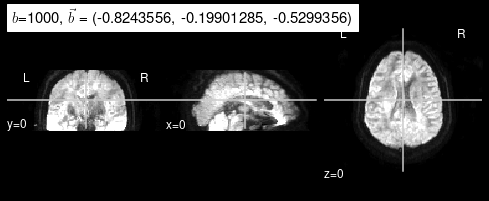

In [11]:
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1], black_bg=True);

In [ ]:
# Elastic Net

In [16]:
model = SparseFascicleModel(gtab=gtab, S0=dmri_dataset.bzero)
model.fit(data_train[0])
predicted = model.predict(data_test[1])

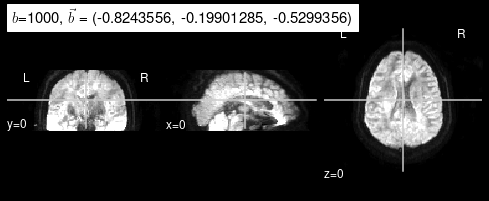

In [17]:
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1], black_bg=True);

In [26]:
predicted.tofile("elasticnet.nii.gz")

In [29]:
predicted.shape

(128, 128, 50)

In [30]:
dmri_dataset.dataobj.shape

(128, 128, 50, 71)